In [1]:
import numpy as np 
import matplotlib.pyplot as pl
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import Akima1DInterpolator
from scipy.stats import multivariate_normal
import time 
#import corner
import h5py
#import ipdb
from scipy import integrate 
#from tqdm import tqdm

# Basic definitions

In [2]:
# magnitude of speed of light
cmag = 149896229 / 500

- Note: 

        zbins is an array of all the edges of the redshift bins that we use -- this parameter will be useful for integration purposes and for omegade 

        zBinsFisher is an array that does not contain the zmin = 0.03

In [3]:
# Redshifts for the bins that we chose when we did the eigevector analysis with Fisher.
Nx = 500
zzmin = 0.03
zzmax = 1.7
zBinsFisher = [zzmin + i * (zzmax - zzmin) / Nx for i in range(1, Nx + 1)]
zbins = np.insert(zBinsFisher, 0, 0.03)

- Import the eigenfunctions from the mathematica output file.

In [4]:
# eigenvectors = np.loadtxt("/gpfs/home/argiannakopo/cosmo_stuff/eigenvectorsFisherTot.dat")
eigenvectors = np.loadtxt("/mnt/c/Users/asgia/Desktop/cosmo_stuff/eigenvectorsFisherTot.dat")
eigenvectors.shape

(500, 500)

In [5]:
## Define DE equation of state as a sum over the eigenvectors times some coefficient alpha

# This function returns an array [1, number of z bins] which corresponds DE EoS for each redshift in each bin.
def w(alphas,eigenvectors):
    
    weighted_eigenvectors = alphas[:,np.newaxis] * eigenvectors

    summed_vector = -1 + np.sum(weighted_eigenvectors, axis=0)

    return -1 + summed_vector
    
    

In [6]:
# Test variables used to make sure things work. They have no meaning.
testbins = np.linspace(0.01,1,5)
testalp = np.linspace(0.01, 0.1, 5)
testvecs = np.array([[1] * 5 for _ in range(5)])
testsigma2 = np.linspace(0.1,0.2,5)

**IMPORTANT NOTE**
- **Here I have assumed that I am interested in $z \in [0.03,1.7]$ and defined 500 bins in this range**

In [7]:
def aux(z1, z2, w1):
    return ( (1 + z2) / (1 + z1) ) ** (3*(1 + w1))

def omegade(zbins, alphas, eigenvectors):
    w_values = w(alphas, eigenvectors)
    N = len(w_values)
    if len(zbins) != N + 1 :
        raise ValueError("Number of zbins is not correct")
        
    cumulative_product = []
    current_product = 1
        
    for i in range(N):
        current_product *= aux(zbins[i], zbins[i+1], w_values[i])
        cumulative_product.append(current_product)
        
    return np.array(cumulative_product)
    


- Interpolate OmegaDE so that I can use it later in the integral of the comoving distance. 

In [8]:
## Interpolation -- Only works within the range of redshifts in zbins array. 

def omegade_interp(zbins, alphas, eigenvectors):

    omegade_values = omegade(zbins, alphas, eigenvectors)
    
    # Use the full range of zbins
    z_points = zbins

    y_points = np.concatenate((omegade_values, [omegade_values[-1]]))
    
    # Create the Akima interpolation
    akima_interp = Akima1DInterpolator(z_points, y_points)
    
    # Wrapper function to handle input outside the zbins range where I assume that we are not in a ΛCDM regime with w = -1
    def bounded_interp(z):
        if z < zbins[0]:
            return 1
        if z > zbins[-1]:
            return omegade_values[-1]
            
        return akima_interp(z)
    
    return bounded_interp


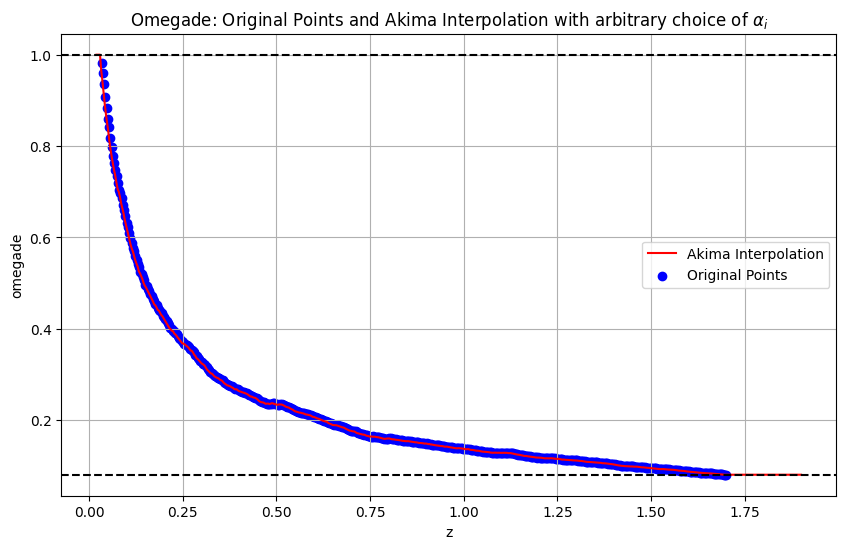

In [24]:
alphastest = np.concatenate((np.array([5,5,5,3,3,3,2,2,2,1]), np.array([0.5] * 490)))
alphastest1 = np.array([1] * 500)
zvals = np.linspace(0.02, 1.9, 600)
omde_interp = omegade_interp(zbins, alphastest, eigenvectors)
omde_values = [omde_interp(z) for z in zvals]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(zvals, omde_values , 'r-', label='Akima Interpolation')
plt.scatter(zBinsFisher, omegade(zbins, alphastest, eigenvectors), color='blue', label='Original Points')

plt.xlabel('z')
plt.ylabel('omegade')
plt.title(r'Omegade: Original Points and Akima Interpolation with arbitrary choice of $\alpha_i$')
plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=omde_interp(1.7), color='black', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

- I will use the interpolated version of the DE density in order to compute the hubble parameter H(z). The interpolated function depends on zbins, alphas  and eigenvectors. To make my code more efficient I will define the interpolation outside of the hubble function. 

In [10]:
## Define Hubble function using the interpolated OmegaDE
## Remeber I need to define the interpolated function before I calculate H(z)


def hubble(z, omegade_interp_fun, H0, Om, Ok):
    x = 1 - Om - Ok 
    if x < 0:
        raise ValueError("Bad input Om, Ok")
    else:        
        return H0 * np.sqrt(Om * ( 1 + z) ** 3 + x * omegade_interp_fun(z) + Ok * (1 +z) **2 )

    

- The way I defined things, I have an issue with luminosity distance $d_L$ since my bins from summing the eigenvectors go from $z_{min}$ to $z_{max}$ with $z_{min} \neq 0$. However, in the definition of the luminosity distance I have an integral from 0 to z. To deal with this part of $z < z_{min}$, I will evaluate a constant factor with $w_{DE} = w_{fid} = -1$ and add this to each element of the array within the zbins that I care about.


In [11]:
# ## I need to figure out how to define angular distance 

# def hubble(zbins, alphas, eigenvectors, H0, Om, Ok ):

#     x = 1 - Om - Ok 
    
#     if x < 0:
#         print("Error: Bad Input, Om, Ok")
#     else:
#         return np.array( H0 * np.sqrt( Om * ( 1 + zbins) ** 3 + x * omegade(zbins, alphas, eigenvectors) + Ok * (1 + zbins)**2) )       


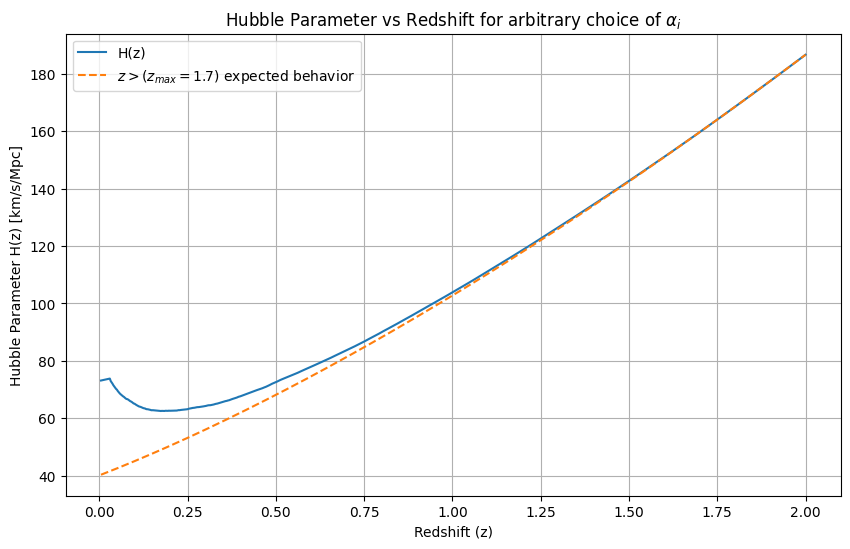

In [13]:
## Example plot of Hubble parameter
zpoints = np.linspace(0.005, 2, 800)
omegade_interp_fun = omegade_interp(zbins, alphastest, eigenvectors)
hubble_values = [hubble(z, omegade_interp_fun, 73, 0.24, 0) for z in zpoints]
# For z > zbins[-1] we expect that the DE component will begome a constant equal to the value shown in the OmegaDE plot above
hubble_lcdm = [73 * np.sqrt(0.24 * (1+z)**3 + (1- 0.24)*omde_interp(1.7)) for z in zpoints]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(zpoints, hubble_values, label='H(z)')
plt.plot(zpoints, hubble_lcdm, linestyle='--', label=r'$z > (z_{max}=1.7)$ expected behavior')
plt.xlabel('Redshift (z)')
plt.ylabel('Hubble Parameter H(z) [km/s/Mpc]')
plt.title(r'Hubble Parameter vs Redshift for arbitrary choice of $\alpha_i$')
plt.legend()
plt.grid(True)
plt.show()

- **Now we are ready to evaluate the comoving distance**

In [41]:
from scipy import integrate

def integrand_comov(z, omegade_interp_fun, H0, Om, Ok):
    return 1 / hubble(z, omegade_interp_fun, H0, Om, Ok)
    
def comov_dist(z, omegade_interp_fun, H0, Om, Ok):
    x = 1 - Om - Ok
    if x < 0:
        raise ValueError('Comoving distance: Bad Input, Om, Ok')
    else:
        # integrate.quad return the value of the integral and the estimate on the absolute error of the result
        # result, _ = integrate.quad(integrand_comov, 0, z, args=(omegade_interp_fun, H0, Om, Ok), limit=1000)
        ## Romberg works with no error messages but takes forever
        # result = integrate.romberg(integrand_comov, 0, z, args=(omegade_interp_fun, H0, Om, Ok), divmax=20)
        result, _ = integrate.quad_vec(lambda x: integrand_comov(x, omegade_interp_fun, H0, Om, Ok), 0 , z)
        return result

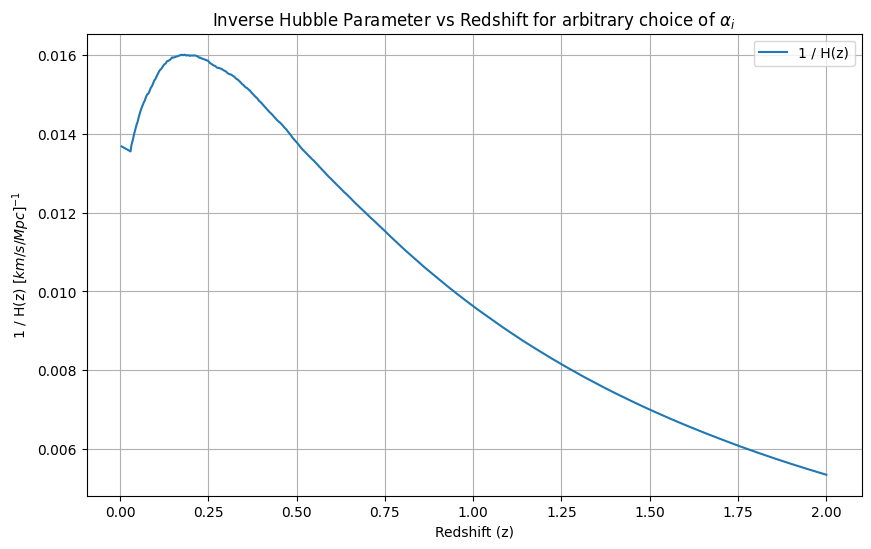

In [42]:
## Example plot of  1/ H(z) to check the shape of the function
#omegade_interp_fun1 = omegade_interp(zbins, alphastest1, eigenvectors)

inv_hubble_points = [integrand_comov(z, omegade_interp_fun, 73, 0.24, 0) for z in zpoints]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(zpoints, inv_hubble_points, label='1 / H(z)')
plt.xlabel('Redshift (z)')
plt.ylabel('1 / H(z) $[km/s/Mpc]^{-1}$')
plt.title(r'Inverse Hubble Parameter vs Redshift for arbitrary choice of $\alpha_i$')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
## Define the comoving distance. 
## Since the zbins start at zmin, I will break the integral in two pieces: [0,zmin) and [zmin,z]

# ## This function return a numpy array that gives the comoving distance at each redshift bin. 
# def comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok):
#     x = 1 - Om - Ok
#     if x < 0:
#         return print('Comoving dist: Bad Input, Om, Ok')
#     else:
#         # Bin the [0, zmin] interval and do the integration
#         x1, x2 = 0, zbins[0]
#         Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#         dx = (x2 - x1) / Nx
#         dz = zbins[1] - zbins[0]
#         less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (H0 * np.sqrt(Om * (1 + x1 + dx * i)**3 + x * (1+ x1 + dx * i) + Ok * (1 + x1 + dx * i)**2)))(i) for i in range(0, Nx))
#         less_zmin =  np.sum(less_zmin_arr)
        
#         return cmag * less_zmin +  cmag * np.cumsum( dz / hubble(zbins, alphas, eigenvectors, H0, Om, Ok))
    
## Define the comoving distance. 
## Since the zbins start at zmin, I will break the integral in two pieces: [0,zmin) and [zmin,z]

# ###########################################################################################################
# ## This function return a numpy array that gives the comoving distance at each redshift bin. 
# def comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok):
#     x = 1 - Om - Ok
#     if x < 0:
#         return print('Comoving dist: Bad Input, Om, Ok')
#     else:
#         # Write the comoving distance function for z < zmin where w_de = -1, so that I can use scipy to do the integration for that part
#         def f(x1,x, H0, Om, Ok):
#             return 1 / ( H0 * np.sqrt( Om * pow(1+x1 ,3 ) + x * (1 + x1) + Ok * pow(1+x1, 2)))
            
#         less_zmin = integrate.quad(f, 0, zbins[0], args=(x, H0, Om, Ok))
#         # # Bin the [0, zmin] interval and do the integration
#         # x1, x2 = 0, zbins[0]
#         # Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#         # dx = (x2 - x1) / Nx
#         dz = zbins[1] - zbins[0]
#         # less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (H0 * np.sqrt(Om * (1 + x1 + dx * i)**3 + x * (1+ x1 + dx * i) + Ok * (1 + x1 + dx * i)**2)))(i) for i in range(0, Nx))
#         # less_zmin =  np.sum(less_zmin_arr)
       
#         return cmag * less_zmin[0] +  cmag * np.cumsum( dz / hubble(zbins, alphas, eigenvectors, H0, Om, Ok))
    
    

In [43]:
## Define the luminosity distance using the comoving distance function that returns a single value instead of an array
def lum_distance(z, omegade_interp_fun, H0, Om, Ok):
    return (1 + z) * comov_dist(z, omegade_interp_fun, H0, Om, Ok)

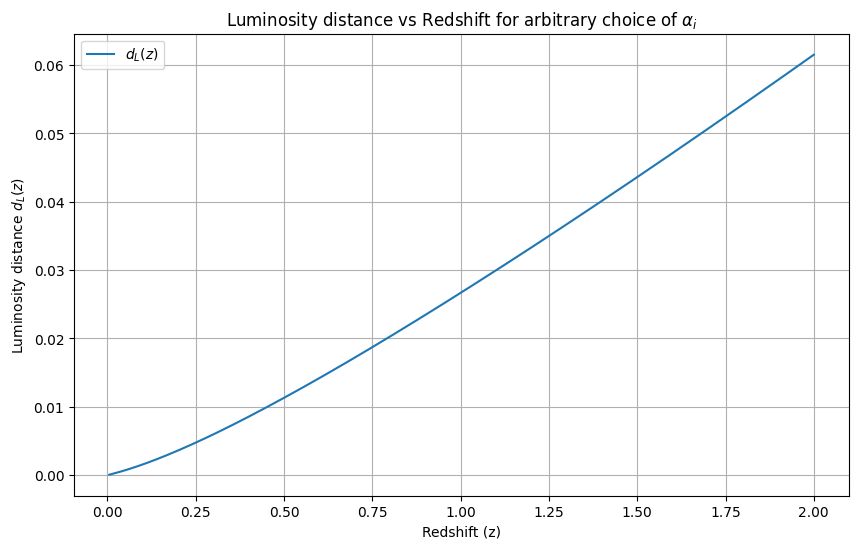

In [44]:
lum_dist_points = [lum_distance(z, omegade_interp_fun, 73, 0.24, 0) for z in zpoints]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(zpoints, lum_dist_points, label=r'$d_L(z)$')
plt.xlabel('Redshift (z)')
plt.ylabel(r'Luminosity distance $d_L(z)$')
plt.title(r'Luminosity distance vs Redshift for arbitrary choice of $\alpha_i$')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
## Returns an array of luminosity distances at each redshift z 
def lum_distance(zbins, alphas, eigenvectors, H0, Om, Ok):
    z_shifted = 1 + zbins

    return z_shifted * comov_dist(zbins, alphas, eigenvectors, H0, Om, Ok)
    

In [13]:
# ## Testing
# lum_distance(testbins, testalp, testvecs, 73, 0.24, 0.0)

In [14]:
# Define the logarithm of dL
# Returns the logarithm of the array of luminosity distance for each redshift bin
def log_h0dl(zbins, alphas, eigenvectors, H0, Om, Ok):
    return np.log10( (H0 / cmag) * lum_distance(zbins, alphas, eigenvectors, H0, Om, Ok))
    



In [15]:
# ## Testing
# start_time = time.time()
# x = log_h0dl(testbins, testalp, testvecs, 74, 0.24, 0.0)
# end_time = time.time()
# print("time it took:", end_time - start_time)
# x


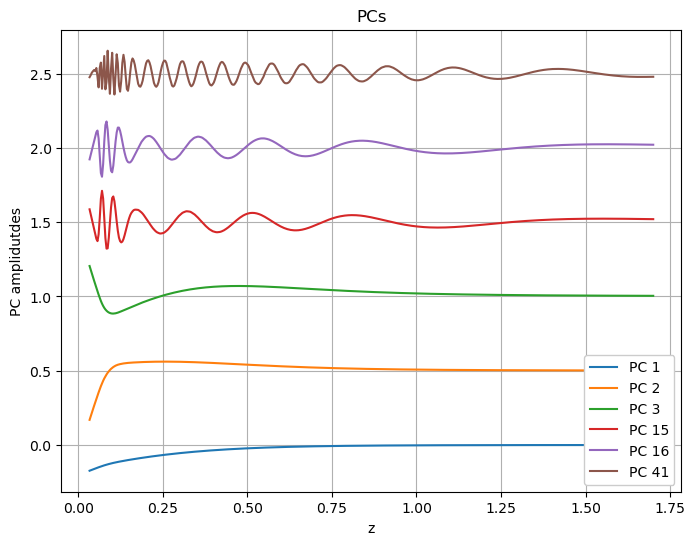

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(zBinsFisher, eigenvectors[0][:], label='PC 1' )
plt.plot(zBinsFisher, 0.5 + eigenvectors[1][:], label='PC 2')
plt.plot(zBinsFisher, 1 + eigenvectors[2][:], label='PC 3')
plt.plot(zBinsFisher, 1.5 + eigenvectors[14][:], label='PC 15')
plt.plot(zBinsFisher, 2 + eigenvectors[15][:], label='PC 16')
plt.plot(zBinsFisher, 2.5 + eigenvectors[40][:], label='PC 41')
plt.grid()
plt.xlabel('z')
plt.ylabel('PC amplidutdes')
#plt.yscale('log')
plt.title('PCs')
plt.legend(loc='lower right',framealpha=1)
plt.show()

# SN $\sigma^2$ definition

In [19]:
NSN = [0, 300, 35, 64, 95, 124, 150, 171, 183, 179, 170, 155, 142, 130, 119, 107, 94, 80, 0]
zSN = [0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.75]
SNpoints = list(zip(zSN, NSN))


In [20]:
# Create an interpolation function for the number of SN 

fNSN = interp1d(zSN, NSN, kind='linear', fill_value='extrapolate')


# # Generate new z values for interpolation
# z_values_interpolated = np.linspace(min(zSN), max(zSN), 1000)

# # Interpolate NSN values for the new z values
# NSN_interpolated = fNSN(z_values_interpolated)


In [21]:
# This function returns the sigma^2 error defined in equation (A2)

def Sigma2SNFisher(i, Nz, zBinsFisher):        

    if i > len(zBinsFisher):
        raise ValueError("Index 'i' is out of range.")

    dz1 = 0.1
    dz2 = 0.07
    tmp = zBinsFisher[1] - zBinsFisher[0]

    z_i = zBinsFisher[i]  

    if z_i < 0.1:
        return dz2 / tmp * (0.15**2 / fNSN(z_i) + 0.02**2 * ((1 + z_i) / 2.7)**2)
    else:
        return dz1 / tmp * (0.15**2 / fNSN(z_i) + 0.02**2 * ((1 + z_i) / 2.7)**2)

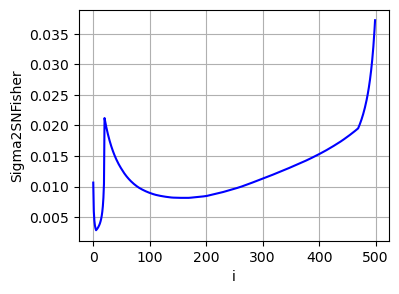

In [22]:
# Test plot to make sure everything works so far

i_values = range(0, len(zBinsFisher))

# Compute Sigma2SNFisher for each i value (each redshift bin of interest)
sigma2_values = [Sigma2SNFisher(i,500,zBinsFisher) for i in i_values]
sigma2_values = np.array(sigma2_values)

# Plot
plt.figure(figsize=(4, 3))
plt.plot(i_values, sigma2_values, linestyle='-', color='b')
plt.xlabel('i')
plt.ylabel('Sigma2SNFisher')
plt.grid(True)
plt.show()

# SN $\chi^2$ definition

In [52]:
#############################################
### NOT SURE THIS IS NEEDED -- CHECK IT ####
###########################################

# # Interpolate the expressions of the eigenfunctions for the z range that I care about [0.03,1.7]
# eigenvec_interp = [[0] * len(eigenvectors[0]) for _ in range(len(eigenvectors))]

# for i in range(len(eigenvectors)):
#     interp_fun = interp1d(zbins, eigenvectors[i], kind='linear')
#     eigenvec_interp[i] = interp_fun(zBinsFisher)

# eigenvec_interp = np.array(eigenvec_interp)
# eigenvec_interp.shape

Now I have a table 500x500 that only includes the eigenvectors in the redshift range that I am interested in. For the rest I need to use zBinsFisher instead of zbins.

In [23]:
# This function takes as input the zbins, amplitudes alpha, eigenvectors,  error values and cosmo parameters
# and returns the chi^2 based on SN (equation A6 from ref)

def chi_squared_sn(alphas, Om, Omh2, Ok, zBinsFisher, eigenvectors, sigma2_values):
    
    H0 = np.sqrt(Omh2/Om) * 100
    # Difference between MCMC model and fiducial model
    alphas_fid = np.array([0] * len(eigenvectors))
    diff = log_h0dl(zBinsFisher, alphas, eigenvectors, H0, Om, Ok) - log_h0dl(zBinsFisher, alphas_fid, eigenvectors, 73, 0.24, 0.0)

    return 5 * np.sum( diff**2 / sigma2_values) - 25 * np.sum(diff / sigma2_values) / np.sum(1 / sigma2_values)  
    


In [54]:
# ## Testing
# chi_squared_sn(testbins, testalp, testvecs, testsigma2, 73, 0.24, 0.0 )

# Definition of CMB part including radiation

In [24]:
# Define some basic parameters following the PCA construnction

NNU = 3.04
TCMB = 2.725
OGhh = 4.4856e-7 * TCMB ** 4
ONhh = 1.0187e-7 * NNU * TCMB ** 4
ORhh = ONhh + OGhh
zrec = 1090

In [25]:
# covariance matrix
CMBCov = np.array([[0.0018**2, -(0.0014)**2],[-(0.0014)**2, 0.0011**2]])
invCMBCov = np.linalg.inv(CMBCov)

- In this case again I need to be careful how I define the distances because I care about $z_{rec}=1090$.

In [26]:
## I need to figure out how to define angular distance 

def hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):

    h2 = Omh2 / Om
    x = h2 - Omh2 - Ok * h2 - ORhh

    if x < 0:
        print("Error: Bad Input, x")
    else:
        return np.array( 100 * np.sqrt( Omh2 * (1 + zbins) ** 3 + x * omegade(zbins, alphas, eigenvectors) + Ok * h2 * (1 + zbins)**3 + ORhh * (1+zbins)**4 ) )



In [27]:
# ## Testing
# hubble_rad(testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0.0, ORhh)

- I need to redefine the comoving distance using the new Hubble function

In [28]:
# ## This function return the comoving distance to redshift z. 
# ## Here I want to extend to redshifts that are zmax of the zbins. 

# def comov_dist_rad(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    
#     h2 = Omh2 / Om
#     x = h2 - Omh2 - Ok * h2 - ORhh
    
#     if x < 0:
#         return print('Comoving dist rad: Bad Input, Om, Ok')
#     else:
#         if z < zbins[0]:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, z
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)
            
#             return cmag * less_zmin 
            
#         if z <= zbins[-1] and z >= zbins[0]:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, zbins[0]
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             dz = zbins[1] - zbins[0]
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)
#             # Use boolean mask to only sum up to z and not the rest of the bins. 
#             z_mask = zbins <= z 
            
#             # Discard the z bins that exceed z
#             zbins = zbins[z_mask]
            
#             # Discard the eigenvector bins that exceed z.
#             eigenvectors = eigenvectors[:,:len(zbins)]
            
#             return cmag * less_zmin +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh))
    
            
#         else:
#             # Bin the [0, zmin] interval and do the integration
#             x1, x2 = 0, zbins[0]
#             Nx = 5 + 5 * int(abs(x2 - x1) * 100)
#             dx = (x2 - x1) / Nx
#             dz = zbins[1] - zbins[0]
#             less_zmin_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx *i) ** 4)))(i) for i in range(0, Nx))
#             less_zmin =  np.sum(less_zmin_arr)

#             x3, x4 = zbins[-1], z
#             Nx2 = 5 + 5 * int(abs(x4 - x3) * 100)
#             dx2 =(x4 - x3 ) / Nx2
#             larger_zmax_arr = Parallel(n_jobs=-1)(delayed(lambda i: dx2 / (100 * np.sqrt(Omh2 * (1 + x1 + dx * i)**3 
#                                                                                       + x * (1+ x1 + dx * i) + Ok * h2 * (1 + x1 + dx * i)**3 + ORhh * (1+ x1 + dx * i) ** 4)))(i) for i in range(0, Nx2))
#             larger_zmax = np.sum(larger_zmax_arr)
            
#             return cmag * less_zmin +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)) + cmag * larger_zmax
            
        

In [29]:
# ## Test
# start_time = time.time()
# x = comov_dist_rad(0.5, testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0, ORhh)
# end_time = time.time()
# print("comp time:", end_time - start_time)
# x


- Faster version to compute comoving distance taking into account radiation. 

In [30]:
## This function return the comoving distance to redshift z. 
## I will try different integration methods to speed things up 

#################################################################
##### Comoving distance using the scipy integrate function #####
###############################################################

def comov_dist_rad_fast(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    
    h2 = Omh2 / Om
    x = h2 - Omh2 - Ok * h2 - ORhh
    dz = zbins[1] - zbins[0]
    
    if x < 0:
        return print('Comoving dist rad: Bad Input, Om, Ok')
    else:
        def f(x1,x, Ok, h2, ORhh):
            return 1 / (100 * np.sqrt(Omh2 * (1 + x1)**3 + x * (1+ x1) + Ok * h2 * (1 + x1 )**3 + ORhh * (1+ x1 ) ** 4))
    
        if z < zbins[0]:
            return cmag * integrate.quad(f,0, z, args=(x, Ok, h2, ORhh))[0]
                
        if z <= zbins[-1] and z >= zbins[0]:
            z_less = integrate.quad(f,0,zbins[0], args=(x, Ok, h2, ORhh))
            # Use boolean mask to only sum up to z and not the rest of the bins. 
            z_mask = zbins <= z 
            
            # Discard the z bins that exceed z
            zbins = zbins[z_mask]
            
            # Discard the eigenvector bins that exceed z.
            eigenvectors = eigenvectors[:,:len(zbins)]
            
            return cmag * z_less[0] +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh))
        if z > zbins[-1]:
            z_less = integrate.quad(f,0,zbins[0],args=(x, Ok, h2, ORhh))
            z_more = integrate.quad(f, zbins[-1], z, args=(x, Ok, h2, ORhh))
            
            return cmag * z_less[0] +  cmag * np.sum( dz / hubble_rad(zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)) + cmag * z_more[0]
            
        

In [31]:
# ## Testing
# start_time = time.time()
# x = comov_dist_rad_fast(0.5, testbins, testalp, testvecs, 0.24*0.73**2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

- The $D_a$ function below works correctly only for redshift values z that are larger than the range covered by the SN measurements i.e. larger than $z_{max}$ in $z_{bins}$. However, since I only care about the $z_{rec}$ distance, this is not a problem.

In [32]:
## This function returns the angular distance for redshift z. 
## NOTE: This works for z > zbins interval, but since I am interested in zrec that is okay.
def angular_dist(z, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):

    h2 = Omh2 / Om
    comov_dist = comov_dist_rad_fast(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh)
    
    if Ok > 0 :
        return  cmag / ((1 + z ) * 100 * h2 * np.sqrt(np.abs(Ok))) * np.sinh( (1/cmag) * np.sqrt(Ok) * 100 * h2 * comov_dist )   
    
    elif Ok < 0 :
        return cmag / ((1 + z ) * 100 * h2 * np.sqrt(np.abs(Ok))) * np.sin((1/cmag) * np.sqrt(-Ok) * 100 * h2 * comov_dist )
        
    elif Ok == 0:
        return comov_dist / ( 1 + z)
        

In [33]:
# ## Testing
# start_time = time.time()
# x = angular_dist(1090, testbins, testalp, testvecs, 0.24 * 0.73 **2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

In [34]:
def ln_angular_dist(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh):
    return np.log( angular_dist(z,zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh) )

In [35]:
# ## Testing
# start_time = time.time()
# x = ln_angular_dist(1090, testbins, testalp, testvecs, 0.24 * 0.73 **2, 0.24, 0, ORhh)
# end_time = time.time()
# print("compt time:", end_time - start_time)
# x

# CMB $\chi^2$ definition

In [36]:
## Fiducial model angluar distance to z_rec
alphas_fid = np.array([0] * len(eigenvectors))
lnd_angular_rec_fid = ln_angular_dist(zrec, zbins, alphas_fid, eigenvectors, 0.24 * 0.73**2, 0.24, 0.0, ORhh)

In [37]:
# CMB contribution to χ^2

def chi_squared_cmb(alphas, eigenvectors, invCMBCov, lnd_ang_rec_fid, Omh2, Om, Ok, ORhh):
    zrec = 1090
    Omh2_fid = 0.24 * 0.73 ** 2
    diff1 = ln_angular_dist(zrec, zbins, alphas, eigenvectors, Omh2, Om, Ok, ORhh) - lnd_ang_rec_fid 
    diff2 = Omh2 - Omh2_fid
    

    vec = np.array([diff1, diff2])
    return np.matmul( np.matmul(vec,invCMBCov), vec)   


# Priors

- Refer to equation (A8) from Mortonson et al 0810.1744
- Each one of the priors is written as the logarithm of a Gaussian pdf with variance sigma and mean being the fiducial model. Note that in the definition of the following function I have used the fiducial model values directly, so if I need to redefine which is my fiducial model then I need to revise the definition in this function.

- **For the theoretical prior on the DE equation of state w(z)**
  
We first choose the class of models that we are interested in, i.e. $w_{min} \leq w \leq w_{max}$. Then we need to go through the projection stuff that they describe in the paper such that we extract the resulting constraints on the amplitudes $\alpha_i$. If I want to use the result from the first method that they describe (eq. A(10) in 0810.1744) then I need to know the eigenvectors and I need to sum over all of them. On the other hand, I can be sneaky and use equation (A13) which combines the two methods that they quote. This way I completely avoid dealing with the eigenvectors.

*Is it the case that I don't need to worry about which exactly $\alpha_i$ I am technically sampling from since I can assume that their distributions will be the same? This would also come from the fact that there is a $\mathcal{O}(N_{z,PC})$ symmetry in equation (A13)*

In [38]:
# Angular distance to z=0.35 in the fiducial model
ln_angular_0p35_fid = ln_angular_dist(0.35, zbins, alphas_fid, eigenvectors, 0.24 * 0.73 ** 2, 0.24, 0.0, ORhh)


For the theory prior below, I can rewrite equation (A10) as:

$ \alpha_i^{\pm} = \frac{1}{2N_{z,PC}} \left[ \left( w_{min} + w_{max} - 2 w_{fid} \right) \sum_{j=1}^{N_{z,PC}} e_i (z_j) \pm \left( w_{max} - w_{min} \right) \sum_{j=1}^{N_{z,PC}} \lvert e_i (z_j) \rvert \right]$.

Taking advangate of that, I first calculate the two sums, then weigh the arrays appropriately and sum/take the difference.

In [39]:
## In order to define the correct prior for the PC amplitudes, I need to define the allowed min and max values for each alpha_i.
## I can do that outside of the function that I will write below since these things do not change with each random step that the MCMC makes

# Theoretical limits on DE
wfid = -1
# Quintessence
wmin, wmax = -1, 1
# Smooth DE
# wmin, wmax = -5, 3
weight1 = wmin + wmax - 2 * wfid
weight2 = wmax - wmin 

# First I need to calculate each of the two relevant sums in the eq (A10)
first_sum = np.sum(eigenvectors, axis=1)
second_sum = np.sum(np.abs(eigenvectors), axis=1)

## Nz is the number of z bins I used 
Nz = 500

# alpha_max and alpha_min are two arrays that are storing the max and min value of the amplitudes alpha_i 
alpha_max = ( 1 / (2*Nz)) * ( weight1 * first_sum + weight2 * second_sum)
alpha_min = ( 1 / (2*Nz)) * ( weight1 * first_sum - weight2 * second_sum)

- **I will first start by only using the prior on the PCs, not the other ones included in eq. A5 of 0810.1744.**

In [40]:
def chi_squared_prior(alphas, alpha_max, alpha_min):
    if np.any(alphas < alpha_min[:15]) or np.any(alphas > alpha_max[:15]):
        return -np.inf
    return 0 

In [41]:
# # prior 

# def chi_squared_prior(eigenvectors, eigenvectorsNc, alphas, alpha_max, alpha_min, zbins, Omh2, Om, Ok, ORhh, ln_angular_0p35_fid):

# #     # Amplitudes prior 
# #     # Theoretical limits on DE
# #     wfid = -1
# #     # Quintessense 
# #     wmin, wmax = -1, 1
# #     # Smooth DE
# #     # wmin, wmax = -5, 3

# #     weight1 = wmin + wmax - 2 * wfid
# #     weight2 = wmax - wmin 

# #     # First I need to calculate each of the two relevant sums in the eq (A10)
# #     first_sum = np.sum(eigenvectors, axis=1)
# #     second_sum = np.sum(np.abs(eigenvectors), axis=1)
    
# #     # alpha_max and alpha_min are two arrays that are storing the max and min value of the amplitudes alpha_i 
# #     alpha_max = ( 1 / (2*Nz)) * ( weight1 * first_sum + weight2 * second_sum)
# #     alpha_min = ( 1 / (2*Nz)) * ( weight1 * first_sum - weight2 * second_sum)

#     # Top hat prior on the amplitudes.
#     # Here I have assumed that I am only intrested in the first 15 alphas i.e. I only want to keep the first 15 eigenfunctions. 
#     # ## NOTE: Be very careful with the definition of the if not statement! 
#     # if  not (np.all(alphas < alpha_max[:2]) and not np.all(alphas > alpha_min[:2])):
#     #     return - np.inf
#     if np.any(alphas < alpha_min[:15]) or np.any(alphas > alpha_max[:15]):
#         return -np.inf
    
#     # h prior
#     sigma_h = 0.08
#     h_prior = -0.5 * ( np.sqrt(Omh2 / Om) - 0.73) ** 2 / sigma_h ** 2
    
#     # BAO prior
#     sigma_bao = 0.037
#     bao_prior = -0.5 * ( ln_angular_dist(0.35, zbins, alphas, eigenvectorsNc, Omh2, Om, Ok, ORhh) - ln_angular_0p35_fid ) ** 2 / sigma_bao ** 2
    
#     # WMAP prior on DE
#     sigma_de = 0.025
#     de_prior = - 0.5 * ( (1 - Om - Ok) - (1 - 0.24)) ** 2 / sigma_de ** 2
    
#     # out = h_prior + bao_prior + de_prior
#     # if (out < 0  and out > -0.05) or out > 10**5:
#     #     print(h_prior, bao_prior, de_prior)
    
#     return h_prior + bao_prior + de_prior   
    

# Uniform Sampling

In [50]:
## In order to define the correct prior for the PC amplitudes, I need to define the allowed min and max values for each alpha_i.
## I can do that outside of the function that I will write below since these things do not change with each random step that the MCMC makes

# Theoretical limits on DE
wfid = -1
# Quintessence
wmin, wmax = -1, 1
# Smooth DE
# wmin, wmax = -5, 3
weight1 = wmin + wmax - 2 * wfid
weight2 = wmax - wmin 

# First I need to calculate each of the two relevant sums in the eq (A10)
first_sum = np.sum(eigenvectors, axis=1)
second_sum = np.sum(np.abs(eigenvectors), axis=1)

## Nz is the number of z bins I used 
Nz = 500

# alpha_max and alpha_min are two arrays that are storing the max and min value of the amplitudes alpha_i 
alpha_max = ( 1 / (2*Nz)) * ( weight1 * first_sum + weight2 * second_sum)
alpha_min = ( 1 / (2*Nz)) * ( weight1 * first_sum - weight2 * second_sum)

In [51]:
alpha_max[0], alpha_min[0]


(0.0, -0.047306888377028816)

- I will sample only for $\alpha_1$, $\Omega_m$ and $\Omega_m h^2$. I will set to zero the rest of the PCs. Also, note that based on the calculation in the previous cell, I know the min and max values that are allowed for $\alpha_1$.
- The following should create two .h5 files that contain the cosmological parameters and the respective values for logdL, so that I can use them for training my ResMLP.

In [52]:
## Define the limits of the sampling region -- ([alphas], Omega_m, Omega_mh^2) 
## The fiducial model that I am using has Omega_m = 0.24 and h = 0.73 -- Omega_m h^2 = 0.127896 
low_lim = np.concatenate([alpha_min[:15],[0.14, 0.055566]])
high_lim = np.concatenate([alpha_max[:15],[0.34, 0.234226]])
# low_lim = [alpha_min[0], 0.14 , 0.055566]
# high_lim = [alpha_max[0], 0.34, 0.234226]


In [53]:
test_vec = np.random.uniform(low=low_lim, high=high_lim, size=None)
test_alps = np.concatenate([test_vec[:15], [0]*485]) 
test_vec

array([-0.0272056 ,  0.01962376,  0.00091084,  0.01034417, -0.00872407,
       -0.01888042,  0.03857006,  0.00411252,  0.0038228 , -0.02562287,
       -0.03688682, -0.0184691 ,  0.01349347, -0.03097281, -0.01906521,
        0.33822625,  0.17690661])

In [54]:
from_alps = log_h0dl(np.linspace(0.0334, 1.7, 500), test_alps, eigenvectors, np.sqrt(test_vec[16]/test_vec[15])*100, test_vec[15],0)


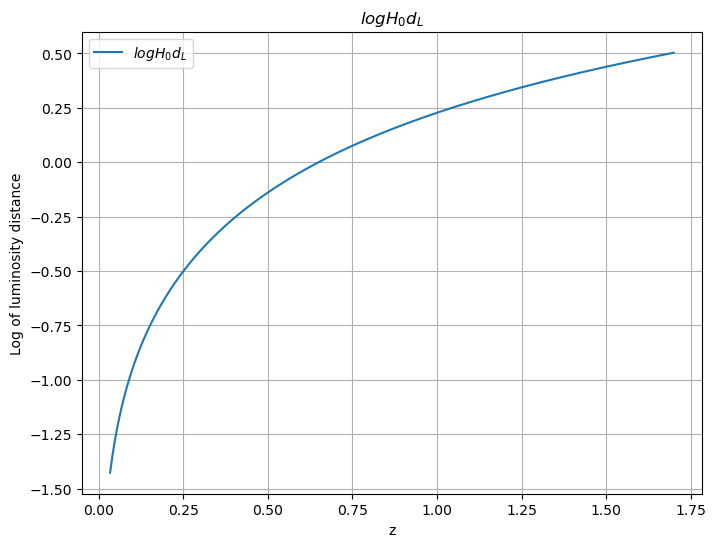

In [55]:
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.0334, 1.7, 500), from_alps, label=r'$logH_0d_L$')

plt.grid()
plt.xlabel('z')
plt.ylabel('Log of luminosity distance')
#plt.yscale('log')
plt.title(r'$logH_0d_L$')
plt.legend()
plt.show()

In [22]:
## Will save the uniform sampled cosmological parameters in an hdf5 file
with h5py.File('/gpfs/scratch/argiannakopo/uniform_cosmo_data_15PC.h5', 'w') as f:
    # Will save things in chunks so that it is easier to load and read later
    dataset = f.create_dataset('data', shape=(0, 17), maxshape=(None, 17), dtype=np.float64, chunks=True)

    chunk_size = 100000  # Number of rows per chunk
    for start in range(0, 100000, chunk_size):
        end = min(start + chunk_size, 100000)
        chunk = np.random.uniform(low=low_lim, high=high_lim, size=(end - start, 17))
        dataset.resize((dataset.shape[0] + chunk.shape[0]), axis=0)
        dataset[-chunk.shape[0]:] = chunk


In [23]:
# Input and output file names
input_filename = '/gpfs/scratch/argiannakopo/uniform_cosmo_data_15PC.h5'
output_filename = '/gpfs/scratch/argiannakopo/uniform_lodL_data_15PC.h5'
zeros = [0] * (500 - 15)

# Read the input file and process each row
with h5py.File(input_filename, 'r') as f_in, h5py.File(output_filename, 'w') as f_out:
    dataset_in = f_in['data']
    num_rows, num_cols = dataset_in.shape
    
    
    dataset_out = f_out.create_dataset('processed_data', shape=(num_rows, 500), dtype=np.float64, chunks=True)
    
    # Process each row and save the result
    for i in range(num_rows):
        row = dataset_in[i]
        alps = np.concatenate([row[:15],zeros])  
        processed_row = log_h0dl(zBinsFisher, alps, eigenvectors, np.sqrt(row[-1]/row[-2])*100, row[-2], 0)
        dataset_out[i] = processed_row

print("Processing complete. Data saved to:", output_filename)


KeyboardInterrupt: 

# Uniform Sampling for the Second PC

In [49]:
## Define the limits of the sampling region -- (alpha_1, Omega_m, Omega_mh^2) 
## The fiducial model that I am using has Omega_m = 0.24 and h = 0.73 -- Omega_m h^2 = 0.127896 
low_lim = [alpha_min[1], 0.14 , 0.055566]
high_lim = [alpha_max[1], 0.34, 0.234226]

In [50]:
## Will save the uniform sampled cosmological parameters in an hdf5 file
with h5py.File('uniform_cosmo_data_secondPC.h5', 'w') as f:
    # Will save things in chunks so that it is easier to load and read later
    dataset = f.create_dataset('data', shape=(0, 3), maxshape=(None, 3), dtype=np.float64, chunks=True)

    chunk_size = 1000  # Number of rows per chunk
    for start in tqdm(range(0, 10000, chunk_size)):
        end = min(start + chunk_size, 10000)
        chunk = np.random.uniform(low=low_lim, high=high_lim, size=(end - start, 3))
        dataset.resize((dataset.shape[0] + chunk.shape[0]), axis=0)
        dataset[-chunk.shape[0]:] = chunk

# Input and output file names
input_filename = 'uniform_cosmo_data_secondPC.h5'
output_filename = 'uniform_lodL_data_secondPC.h5'
zeros = [0] * 499

# Read the input file and process each row
with h5py.File(input_filename, 'r') as f_in, h5py.File(output_filename, 'w') as f_out:
    dataset_in = f_in['data']
    num_rows, num_cols = dataset_in.shape
    
    
    dataset_out = f_out.create_dataset('processed_data', shape=(num_rows, 500), dtype=np.float64, chunks=True)
    
    # Process each row and save the result
    for i in tqdm(range(num_rows)):
        row = dataset_in[i]
        alps = np.insert(zeros, 1, row[0])                
        processed_row = log_h0dl(zBinsFisher, alps, eigenvectors, np.sqrt(row[2]/row[1])*100, row[1], 0)
        dataset_out[i] = processed_row

print("Processing complete. Data saved to:", output_filename)



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 359.82it/s]

Processing complete. Data saved to: uniform_lodL_data_secondPC.h5


# Uniform Sampling 2 PCs 

In [40]:
## Define the limits of the sampling region -- (alpha_1, Omega_m, Omega_mh^2) 
## The fiducial model that I am using has Omega_m = 0.24 and h = 0.73 -- Omega_m h^2 = 0.127896 
low_lim = [alpha_min[0], alpha_min[1], 0.14 , 0.055566]
high_lim = [alpha_max[0], alpha_max[1], 0.34, 0.234226]

In [41]:
## Will save the uniform sampled cosmological parameters in an hdf5 file
with h5py.File('uniform_cosmo_data_2PC.h5', 'w') as f:
    # Will save things in chunks so that it is easier to load and read later
    dataset = f.create_dataset('data', shape=(0, 4), maxshape=(None, 4), dtype=np.float64, chunks=True)

    chunk_size = 1000  # Number of rows per chunk
    for start in tqdm(range(0, 50000, chunk_size)):
        end = min(start + chunk_size, 50000)
        chunk = np.random.uniform(low=low_lim, high=high_lim, size=(end - start, 4))
        dataset.resize((dataset.shape[0] + chunk.shape[0]), axis=0)
        dataset[-chunk.shape[0]:] = chunk


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2224.55it/s]


In [42]:
# Input and output file names
input_filename = 'uniform_cosmo_data_2PC.h5'
output_filename = 'uniform_lodL_data_2PC.h5'
zeros = [0] * 498

# Read the input file and process each row
with h5py.File(input_filename, 'r') as f_in, h5py.File(output_filename, 'w') as f_out:
    dataset_in = f_in['data']
    num_rows, num_cols = dataset_in.shape
    
    
    dataset_out = f_out.create_dataset('processed_data', shape=(num_rows, 500), dtype=np.float64, chunks=True)
    
    # Process each row and save the result
    for i in tqdm(range(num_rows)):
        row = dataset_in[i]
        alps = np.concatenate([[row[0],row[1]],zeros])                
        processed_row = log_h0dl(zBinsFisher, alps, eigenvectors, np.sqrt(row[3]/row[2])*100, row[2], 0)
        dataset_out[i] = processed_row

print("Processing complete. Data saved to:", output_filename)


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:37<00:00, 513.69it/s]

Processing complete. Data saved to: uniform_lodL_data_2PC.h5
